## Import libraries

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import Ridge, Lasso
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTEN, SMOTENC
warnings.filterwarnings('ignore')

In [ ]:
pip install -U scikit-learn

In [ ]:
pip install -U imbalanced-learn

In [72]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Load Data

In [2]:
df = pd.read_csv("Telco_customer_churn.csv")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## Pre-processing

#### Inspect column type

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

#### Set Numeric Column Type

In [4]:
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

#### Drop columns

Add back to the Customer ID and dropped location data and columns of similar nature and only retain Churn Value as the predictor.

In [5]:
df = df.drop([ 'Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 'Churn Label', 'Churn Score', 'Churn Reason'], axis=1)

#### Check Null Value

There are 11 null values in total charges. We decide to remove them directly.

In [6]:
df.isnull().sum()

CustomerID            0
Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Value           0
CLTV                  0
dtype: int64

In [7]:
df = df.dropna()
df.isnull().sum()

CustomerID           0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
CLTV                 0
dtype: int64

#### Feature Engineering

Instead of total charges or monthly charges, we decide to use charges per month as the only predictor for charges.

In [8]:
df['ChargesPerMonth'] = df['Total Charges'] / df['Tenure Months']

In [9]:
df = df.drop(['Total Charges', 'Monthly Charges'], axis=1)

#### One-hot encoding

In [10]:
df = pd.get_dummies(df, drop_first=True)
df

,Tenure Months,Churn Value,CLTV,ChargesPerMonth,CustomerID_0003-MKNFE,CustomerID_0004-TLHLJ,CustomerID_0011-IGKFF,CustomerID_0013-EXCHZ,CustomerID_0013-MHZWF,CustomerID_0013-SMEOE,...,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_One year,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check
0,2,1,3239,54.075000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,2,1,2701,75.825000,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2,8,1,5372,102.562500,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,True,False
3,28,1,5003,108.787500,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,True,False
4,49,1,5340,102.781633,False,False,False,False,False,False,...,False,True,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,72,0,5306,19.713889,False,False,False,False,False,False,...,True,False,True,False,False,True,True,False,False,False
7039,24,0,2140,82.937500,False,False,False,False,False,False,...,False,True,False,True,True,False,True,False,False,True
7040,72,0,5560,102.262500,False,False,False,False,False,False,...,False,True,False,True,True,False,True,True,False,False
7041,11,0,2793,31.495455,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


#### Data splitting

We used stratified strategy considering this is an imbalanced dataset.

In [11]:
y = df['Churn Value']
X = df.drop('Churn Value',axis=1)

# Stratified splitting
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2024)

Double check that the stratified train set makes sense.

In [12]:
## check if y_train contains 2 classes

from collections import Counter

print(Counter(y_train_1))

Counter({0: 3614, 1: 1308})


#### Option 1: SMOTENC
SMOTENC: If dataset has both categorical and numerical features, SMOTENC allows us to specify which features are categorical.

In [13]:
# Identify categorical feature indices in X_train
categorical_features = [X_train_1.columns.get_loc(col) for col in X_train_1.select_dtypes(include=['bool', 'object']).columns]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train, y_train = smote_nc.fit_resample(X_train_1, y_train_1)

In [19]:
# smote = SMOTEN(random_state=42)
# X_train, y_train = smote.fit_resample(X_train_1, y_train_1)
print("Original training set size:", X_train_1.shape)
print("Resampled training set size:", X_train.shape)

Original training set size: (4922, 7061)
Resampled training set size: (7228, 7061)


#### Option 2: Apply SMOTE on training data

Apply Smote on training data only helps prevent leaks to test data.

In [13]:
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#### Apply Tomek Links on training data

In [14]:
#tomek_links = TomekLinks()
#X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_train_smote, y_train_smote)

In [15]:
# Inspect the resampled data
#df_smote = pd.concat([pd.DataFrame(X_train_resampled, columns=X.columns), pd.DataFrame(y_train_resampled, columns=['Churn Value'])], axis=1)
#df_smote

#### Standardize the data

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train and cross-validate

In [15]:
# Define l1 and l2 regression models
log_reg_ridge = LogisticRegression(penalty='l2', random_state=42, solver='liblinear')
log_reg_lasso = LogisticRegression(penalty='l1', random_state=42, solver='saga')

In [16]:
from imblearn.pipeline import Pipeline

# Define the pipeline (without SMOTENC, since we applied it manually)
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', log_reg_ridge)
])

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', log_reg_lasso)
])

print(ridge_pipeline.named_steps)

{'scaler': StandardScaler(), 'log_reg': LogisticRegression(random_state=42, solver='liblinear')}


In [17]:
# Define grid search range
param_grid_ridge = {'log_reg__C': [0.01, 0.1, 1, 10, 100]}
param_grid_lasso = {'log_reg__C': [0.005, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [19]:
# Perform grid search on the resampled data
# Grid search for Ridge (L2)
ridge_search = GridSearchCV(ridge_pipeline, param_grid_ridge, cv=5, scoring='accuracy')
ridge_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_reg',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'log_reg__C': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [20]:
# Grid search for LASSO (L1)
lasso_search = GridSearchCV(lasso_pipeline, param_grid_lasso, cv=5, scoring='accuracy')
lasso_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log_reg',
                                        LogisticRegression(penalty='l1',
                                                           random_state=42,
                                                           solver='saga'))]),
             param_grid={'log_reg__C': [0.005, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4,
                                        0.5, 0.6, 0.7, 0.8, 0.9]},
             scoring='accuracy')

In [21]:
# Best parameters and scores
print("Best Ridge (L2) Params:", ridge_search.best_params_)
print("Best Ridge (L2) CV Score:", ridge_search.best_score_)

print("Best LASSO (L1) Params:", lasso_search.best_params_)
print("Best LASSO (L1) CV Score:", lasso_search.best_score_)

Best Ridge (L2) Params: {'log_reg__C': 0.01}
Best Ridge (L2) CV Score: 0.7664699660679503
Best LASSO (L1) Params: {'log_reg__C': 0.025}
Best LASSO (L1) CV Score: 0.8216757359521794


The best parameter for Ridge is 0.01.
The best parameter for LASSO is 0.025.

#### Evaluate on the test set

Evaluating the best models on the test set, the accuracy is only 0.6853 and 0.6161 for Ridge and LASSO respectively.

In [22]:
# Evaluate on test set with best models
ridge_best_pipeline = ridge_search.best_estimator_
lasso_best_pipeline = lasso_search.best_estimator_

ridge_test_score = ridge_best_pipeline.score(X_test, y_test)
lasso_test_score = lasso_best_pipeline.score(X_test, y_test)

print("Ridge Test Score:", ridge_test_score)
print("LASSO Test Score:", lasso_test_score)

Ridge Test Score: 0.6663507109004739
LASSO Test Score: 0.7834123222748816


In [23]:
# Predict probabilities for the test set
ridge_probs = ridge_best_pipeline.predict_proba(X_test)[:, 1]
lasso_probs = lasso_best_pipeline.predict_proba(X_test)[:, 1]

In [24]:
# Predict classes for the test set
ridge_preds = ridge_best_pipeline.predict(X_test)
lasso_preds = lasso_best_pipeline.predict(X_test)

In [25]:
# Calculate metrics for Ridge (L2)
ridge_accuracy = accuracy_score(y_test, ridge_preds)
ridge_recall = recall_score(y_test, ridge_preds)
ridge_precision = precision_score(y_test, ridge_preds)
ridge_auc = roc_auc_score(y_test, ridge_probs)

In [26]:
# Calculate metrics for LASSO (L1)
lasso_accuracy = accuracy_score(y_test, lasso_preds)
lasso_recall = recall_score(y_test, lasso_preds)
lasso_precision = precision_score(y_test, lasso_preds)
lasso_auc = roc_auc_score(y_test, lasso_probs)

In [27]:
# Print metrics
print("Ridge (L2) - Accuracy:", ridge_accuracy)
print("Ridge (L2) - Recall:", ridge_recall)
print("Ridge (L2) - Precision:", ridge_precision)
print("Ridge (L2) - AUC:", ridge_auc)

print("LASSO (L1) - Accuracy:", lasso_accuracy)
print("LASSO (L1) - Recall:", lasso_recall)
print("LASSO (L1) - Precision:", lasso_precision)
print("LASSO (L1) - AUC:", lasso_auc)

Ridge (L2) - Accuracy: 0.6663507109004739
Ridge (L2) - Recall: 0.9269162210338681
Ridge (L2) - Precision: 0.43956043956043955
Ridge (L2) - AUC: 0.8450590283651462
LASSO (L1) - Accuracy: 0.7834123222748816
LASSO (L1) - Recall: 0.7433155080213903
LASSO (L1) - Precision: 0.5712328767123288
LASSO (L1) - AUC: 0.8526017015175106


- Accuracy: The Lasso model (0.7834) performs better on test accuracy compared to the Ridge model (0.6663).
- Recall: Both models achieve high recall scores (Ridge: 0.9296, Lasso: 0.9213), indicating that both models are effective in capturing the actual churn cases. However, Ridge is slightly higher.
- Precision: Lasso has a higher precision (0.5699) compared to Ridge (0.4396), meaning that Lasso makes more accurate predictions when it predicts churn. This reduces the number of false positives compared to Ridge.
- AUC: Both models have high AUC scores, with Lasso slightly outperforming Ridge (Lasso: 0.8526, Ridge: 0.8454). This indicates that both models have good discriminatory power, but Lasso has a slight edge.

Conclusion: Overall, Lasso (L1) regularization performs better than Ridge (L2) in terms of accuracy, precision, and AUC, while maintaining a high recall. Therefore, Lasso may be the preferred choice for this customer churn prediction task, especially if minimizing false positives is important for your business use case.

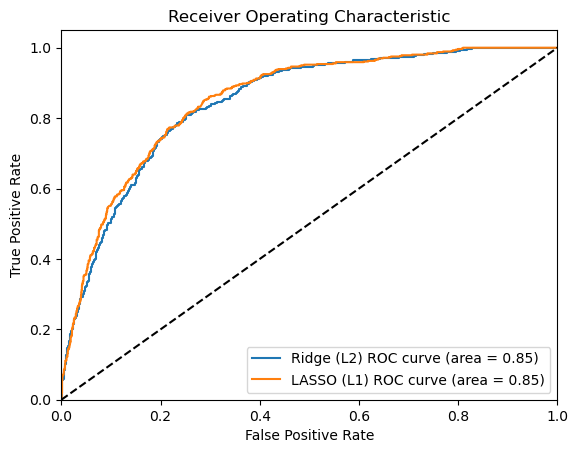

In [28]:
# Plot ROC curves
ridge_fpr, ridge_tpr, _ = roc_curve(y_test, ridge_probs)
lasso_fpr, lasso_tpr, _ = roc_curve(y_test, lasso_probs)

plt.figure()
plt.plot(ridge_fpr, ridge_tpr, label='Ridge (L2) ROC curve (area = %0.2f)' % ridge_auc)
plt.plot(lasso_fpr, lasso_tpr, label='LASSO (L1) ROC curve (area = %0.2f)' % lasso_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Calibration Curve

In [29]:
# Compute calibration curve
ridge_frac_pos, ridge_mean_pred = calibration_curve(y_test, ridge_probs, n_bins=10)
lasso_frac_pos, lasso_mean_pred = calibration_curve(y_test, lasso_probs, n_bins=10)


Logistics regression is supposed to be calibrated natively, but this chart shows otherwise... There are a few reasons for it according to ChatGPT:

1. Imbalanced Data: If the dataset is imbalanced, it can affect the calibration. Ensure proper handling of class imbalance.
2. Regularization: Strong regularization (L1 or L2) can impact the calibration, especially if not tuned properly.
3. Feature Scaling: Ensure that all preprocessing steps, including scaling, are correctly applied.
4. Model Complexity: Logistic regression may not capture complex patterns if the data is non-linear or has complex interactions.
5. Data Quality: Check for noise or outliers in the data that could affect predictions.

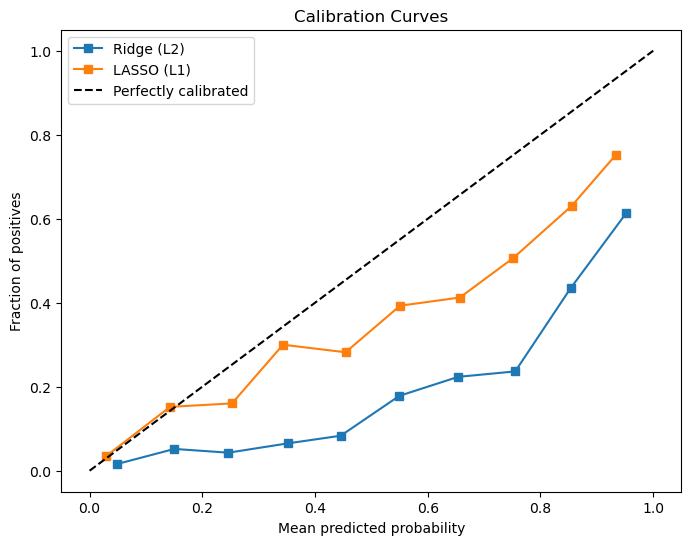

In [30]:
# Plot calibration curves
plt.figure(figsize=(8, 6))
plt.plot(ridge_mean_pred, ridge_frac_pos, "s-", label='Ridge (L2)')
plt.plot(lasso_mean_pred, lasso_frac_pos, "s-", label='LASSO (L1)')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curves')
plt.legend(loc="upper left")
plt.show()

### Understand feature importance

Axes(0.125,0.11;0.775x0.77)


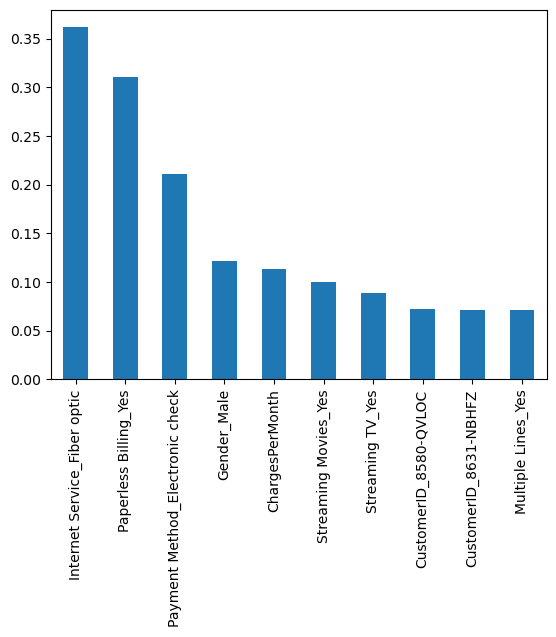

In [31]:
# Get the best LASSO and Ridge models from the grid search
best_ridge_model = ridge_search.best_estimator_.named_steps['log_reg']
best_lasso_model = lasso_search.best_estimator_.named_steps['log_reg']

# Get the coefficients
ridge_coefficients = best_ridge_model.coef_
lasso_coefficients = best_lasso_model.coef_

# Get weights of the first 10 variables for Ridge
weights_ridge = pd.Series(best_ridge_model.coef_[0],
                 index=X.columns.values)
print (weights_ridge.sort_values(ascending = False)[:10].plot(kind='bar'))

Axes(0.125,0.11;0.775x0.77)


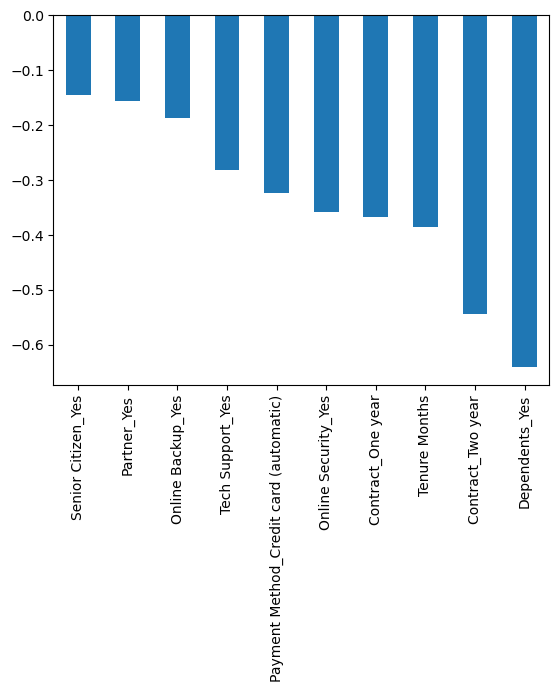

In [32]:
print(weights_ridge.sort_values(ascending = False)[-10:].plot(kind='bar'))


Axes(0.125,0.11;0.775x0.77)


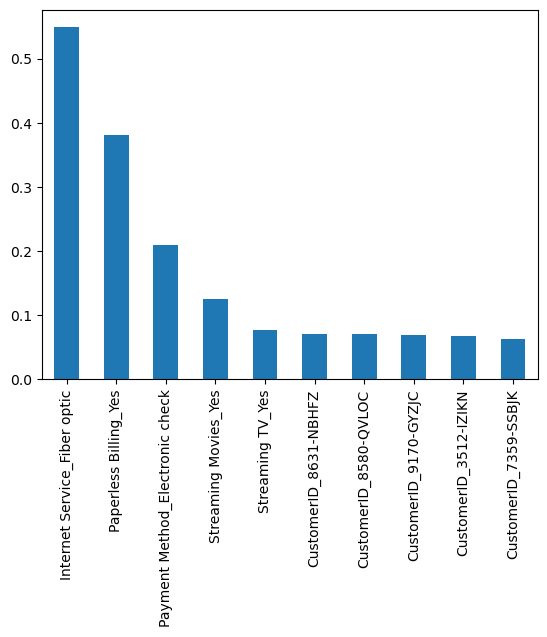

In [33]:
# Get weights of the first 10 variables for LASSO
weights_lasso = pd.Series(best_lasso_model.coef_[0],
                 index=X.columns.values)
print (weights_lasso.sort_values(ascending = False)[:10].plot(kind='bar'))

Axes(0.125,0.11;0.775x0.77)


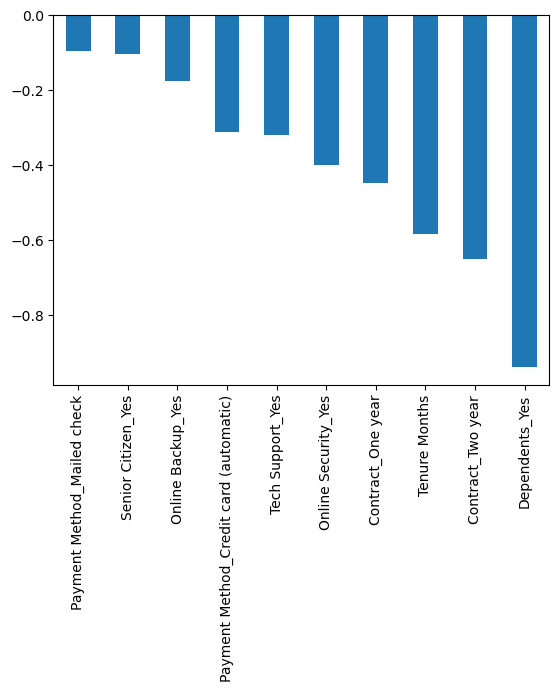

In [34]:
print(weights_lasso.sort_values(ascending = False)[-10:].plot(kind='bar'))


#### Attempt to Calibrate still fail lol 

Use isotonic regression for calibration.

In [44]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

# Create the best models using Ridge and Lasso regularization
log_reg_ridge = LogisticRegression(penalty='l2', C=0.01, random_state=42, solver='liblinear')
log_reg_lasso = LogisticRegression(penalty='l1', C=0.025, random_state=42, solver='saga')

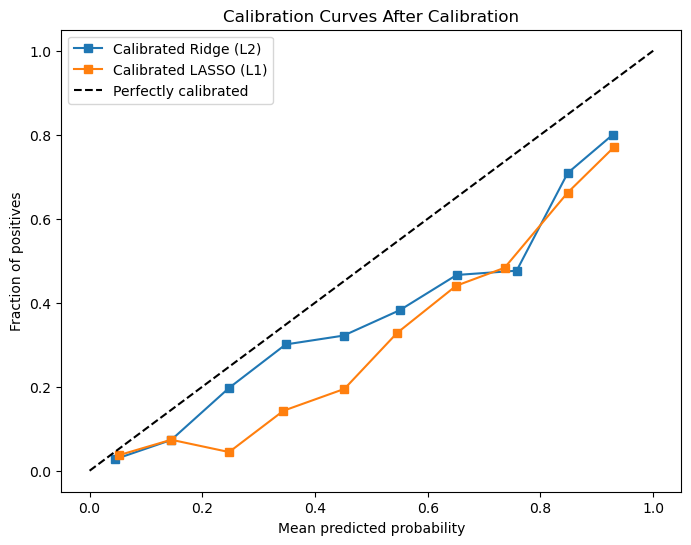

In [45]:
# Fit Ridge and Lasso models on the resampled training data
ridge_model = log_reg_ridge.fit(X_train, y_train)
lasso_model = log_reg_lasso.fit(X_train, y_train)

# Calibrate the Ridge model using Platt scaling and cross-validation
calibrated_ridge = CalibratedClassifierCV(ridge_model, method='sigmoid', cv=5)
calibrated_ridge.fit(X_train, y_train)

# Calibrate the Lasso model using isotonic regression and cross-validation
calibrated_lasso = CalibratedClassifierCV(lasso_model, method='isotonic', cv=5)
calibrated_lasso.fit(X_train, y_train)

# Evaluate calibrated models on test set
ridge_cal_probs = calibrated_ridge.predict_proba(X_test)[:, 1]
lasso_cal_probs = calibrated_lasso.predict_proba(X_test)[:, 1]

# Compute calibration curves for the calibrated models
from sklearn.calibration import calibration_curve

ridge_cal_frac_pos, ridge_cal_mean_pred = calibration_curve(y_test, ridge_cal_probs, n_bins=10)
lasso_cal_frac_pos, lasso_cal_mean_pred = calibration_curve(y_test, lasso_cal_probs, n_bins=10)

# Plot calibration curves after calibration
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(ridge_cal_mean_pred, ridge_cal_frac_pos, "s-", label="Calibrated Ridge (L2)")
plt.plot(lasso_cal_mean_pred, lasso_cal_frac_pos, "s-", label="Calibrated LASSO (L1)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves After Calibration")
plt.legend(loc="upper left")
plt.show()

Improved slightly but not significate enough...

Try using combined calibration, we can first calibrate the model using Platt scaling (method='sigmoid') and then apply a second calibration using isotonic regression (method='isotonic'). 

In [46]:
# Fit base models on the resampled training data
ridge_model = log_reg_ridge.fit(X_train, y_train)
lasso_model = log_reg_lasso.fit(X_train, y_train)

In [47]:
# First Calibration using Platt Scaling (sigmoid method)
calibrated_ridge_platt = CalibratedClassifierCV(ridge_model, method='sigmoid', cv=5)
calibrated_ridge_platt.fit(X_train, y_train)

calibrated_lasso_platt = CalibratedClassifierCV(lasso_model, method='sigmoid', cv=5)
calibrated_lasso_platt.fit(X_train, y_train)

# Get probabilities after first calibration
ridge_platt_probs = calibrated_ridge_platt.predict_proba(X_test)[:, 1]
lasso_platt_probs = calibrated_lasso_platt.predict_proba(X_test)[:, 1]

In [48]:
# Second Calibration using Isotonic Regression
calibrated_ridge_isotonic = CalibratedClassifierCV(calibrated_ridge_platt, method='isotonic', cv=5)
calibrated_ridge_isotonic.fit(X_train, y_train)

calibrated_lasso_isotonic = CalibratedClassifierCV(calibrated_lasso_platt, method='isotonic', cv=5)
calibrated_lasso_isotonic.fit(X_train, y_train)

# Get probabilities after the second calibration
ridge_combined_probs = calibrated_ridge_isotonic.predict_proba(X_test)[:, 1]
lasso_combined_probs = calibrated_lasso_isotonic.predict_proba(X_test)[:, 1]

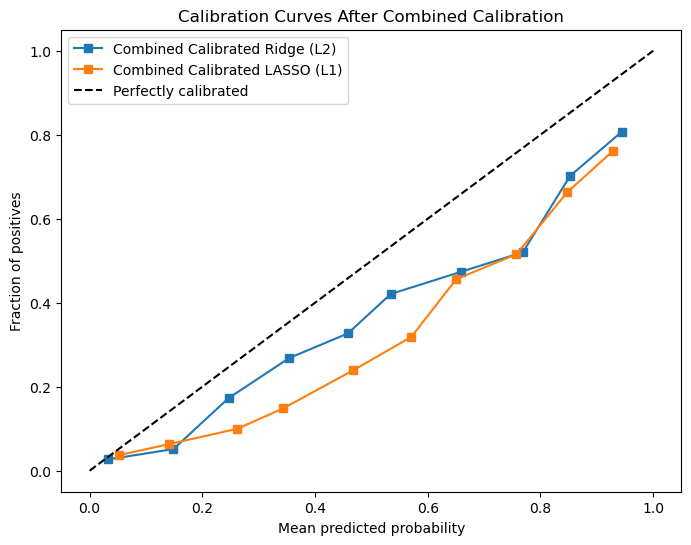

In [49]:
# Compute calibration curves for the combined calibration
ridge_combined_frac_pos, ridge_combined_mean_pred = calibration_curve(y_test, ridge_combined_probs, n_bins=10)
lasso_combined_frac_pos, lasso_combined_mean_pred = calibration_curve(y_test, lasso_combined_probs, n_bins=10)

# Plot the calibration curves after combined calibration
plt.figure(figsize=(8, 6))
plt.plot(ridge_combined_mean_pred, ridge_combined_frac_pos, "s-", label="Combined Calibrated Ridge (L2)")
plt.plot(lasso_combined_mean_pred, lasso_combined_frac_pos, "s-", label="Combined Calibrated LASSO (L1)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves After Combined Calibration")
plt.legend(loc="upper left")
plt.show()

It looks like the combined calibration improved slightly but still isn’t achieving ideal calibration. So let's try the Ensemble Models.  

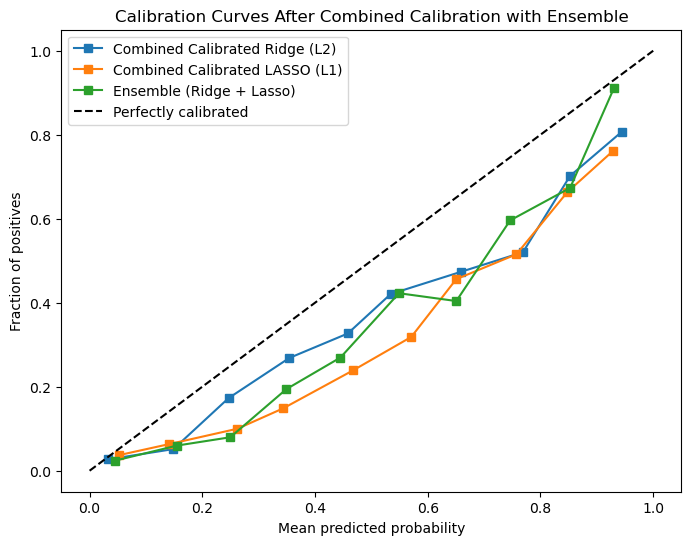

In [50]:
# Average probabilities from calibrated Ridge and Lasso models
ensemble_probs = (ridge_combined_probs + lasso_combined_probs) / 2

# Plot the calibration curve for the ensemble
ensemble_frac_pos, ensemble_mean_pred = calibration_curve(y_test, ensemble_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(ridge_combined_mean_pred, ridge_combined_frac_pos, "s-", label="Combined Calibrated Ridge (L2)")
plt.plot(lasso_combined_mean_pred, lasso_combined_frac_pos, "s-", label="Combined Calibrated LASSO (L1)")
plt.plot(ensemble_mean_pred, ensemble_frac_pos, "s-", label="Ensemble (Ridge + Lasso)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curves After Combined Calibration with Ensemble")
plt.legend(loc="upper left")
plt.show()


#### RANDOM FOREST

Using OPTUNA - to obtain best hyperparameters

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import optuna

# Define the Optuna objective function for tuning
def objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Define the model pipeline with StandardScaler and RandomForestClassifier
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standard scaling
        ('classifier', RandomForestClassifier(  # Random forest with hyperparameters
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        ))
    ])

    # Cross-validation to evaluate model performance 
    score = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# Run the Optuna study to optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)


[I 2024-11-13 15:28:05,127] A new study created in memory with name: no-name-21152226-8481-4e04-aeb0-d2e44631394f
[I 2024-11-13 15:28:13,948] Trial 0 finished with value: 0.7902683976122274 and parameters: {'n_estimators': 111, 'max_depth': 39, 'min_samples_split': 13, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 0 with value: 0.7902683976122274.
[I 2024-11-13 15:28:24,590] Trial 1 finished with value: 0.7870837058127459 and parameters: {'n_estimators': 485, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 7, 'bootstrap': True}. Best is trial 0 with value: 0.7902683976122274.
[I 2024-11-13 15:28:33,737] Trial 2 finished with value: 0.7870834761529926 and parameters: {'n_estimators': 226, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.7902683976122274.
[I 2024-11-13 15:28:42,703] Trial 3 finished with value: 0.7937252936343483 and parameters: {'n_estimators': 215, 'max_depth': 13, 'min_samples_sp

Best hyperparameters: {'n_estimators': 378, 'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True}


Run the model with best parameters using Optuna

Accuracy: 0.7938
Precision: 0.5952
Recall: 0.7023
F1 Score: 0.6443
ROC AUC Score: 0.8527

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1549
           1       0.60      0.70      0.64       561

    accuracy                           0.79      2110
   macro avg       0.74      0.76      0.75      2110
weighted avg       0.81      0.79      0.80      2110



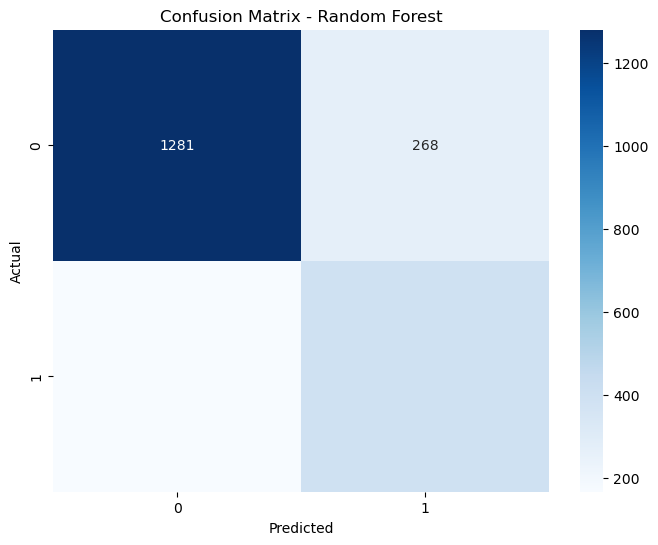

In [57]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train the final model using the best hyperparameters
best_params = study.best_params
final_model_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standard scaling
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        bootstrap=best_params['bootstrap'],
        random_state=42
    ))
])

# Fit the model on the resampled training set
final_model_pipeline.fit(X_train, y_train)

# Evaluate on the test set
y_pred = final_model_pipeline.predict(X_test)
y_pred_proba = final_model_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model with various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

RANDOM FOREST USING CROSS VALIDATION

In [59]:
# Define the Random Forest model
RF_model = RandomForestClassifier(random_state=42)

# Create a pipeline without imbalanced_Pipeline (only using scaler and RF)
RF_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('RF_classifier', RF_model)
])

# Print the pipeline steps to confirm setup
print(RF_pipeline.named_steps)

{'scaler': StandardScaler(), 'RF_classifier': RandomForestClassifier(random_state=42)}


In [61]:
# Define the parameter grid for GridSearchCV
RF_param_grid = {
    'RF_classifier__n_estimators': [50, 100, 150, 200],
    'RF_classifier__max_depth': [10, 15, 20],
    'RF_classifier__min_samples_split': [2, 5, 7],
    'RF_classifier__min_samples_leaf': [2, 4, 6],
    'RF_classifier__bootstrap': [True, False]
}

# Perform GridSearchCV with cross-validation
RF_search = GridSearchCV(RF_pipeline, param_grid=RF_param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
RF_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = RF_search.best_params_
best_model = RF_search.best_estimator_
y_pred_forest = best_model.predict(X_test)

# Print best parameters and accuracy score
print("Best parameters:", best_params)
print("Best model:", best_model)
print("Test Accuracy:", accuracy_score(y_test, y_pred_forest))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'RF_classifier__bootstrap': True, 'RF_classifier__max_depth': 10, 'RF_classifier__min_samples_leaf': 2, 'RF_classifier__min_samples_split': 2, 'RF_classifier__n_estimators': 200}
Best model: Pipeline(steps=[('scaler', StandardScaler()),
                ('RF_classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        n_estimators=200, random_state=42))])
Test Accuracy: 0.7554502369668247


In [62]:
# Training the final model pipeline using the best hyperparameters
RF_final_model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('RF_classifier', RandomForestClassifier(
        n_estimators=best_params['RF_classifier__n_estimators'],
        max_depth=best_params['RF_classifier__max_depth'],
        min_samples_split=best_params['RF_classifier__min_samples_split'],
        min_samples_leaf=best_params['RF_classifier__min_samples_leaf'],
        bootstrap=best_params['RF_classifier__bootstrap'],
        random_state=42
    ))
])

# Fit the final model on the entire training set
RF_final_model_pipeline.fit(X_train, y_train)

# Evaluate the final model on the test set
y_pred_final = RF_final_model_pipeline.predict(X_test)
y_pred_proba_final = RF_final_model_pipeline.predict_proba(X_test)[:, 1]

# Print final evaluation metrics
accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Model Test Accuracy: {accuracy:.4f}")

Final Model Test Accuracy: 0.7555


#### EVALUATE ON THE TEST SET

Accuracy: 0.7555
Precision: 0.5272
Recall: 0.7772
F1 Score: 0.6282
ROC AUC Score: 0.8212
classification report
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1549
           1       0.53      0.78      0.63       561

    accuracy                           0.76      2110
   macro avg       0.71      0.76      0.72      2110
weighted avg       0.80      0.76      0.77      2110



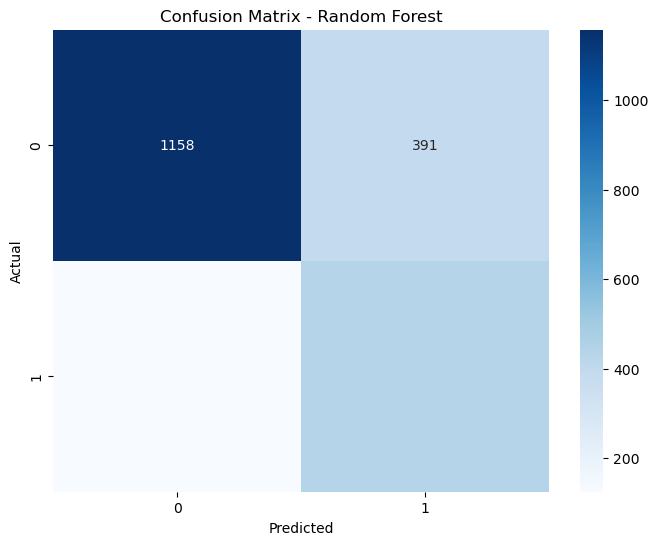

In [63]:
# Make predictions on the test set
y_pred = RF_final_model_pipeline.predict(X_test)
y_pred_proba = RF_final_model_pipeline.predict_proba(X_test)[:, 1]  # for ROC AUC

# Evaluate the model with various metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print the evaluation results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("classification report")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest')
plt.show()

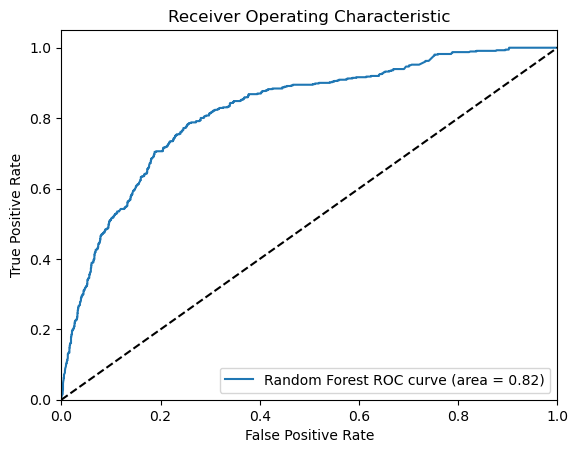

In [64]:
# Plot ROC curves
RF_fpr, RF_tpr, _ = roc_curve(y_test, y_pred_proba)


plt.figure()
plt.plot(RF_fpr, RF_tpr, label='Random Forest ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### CALIBRATION CURVE - RANDOM FOREST

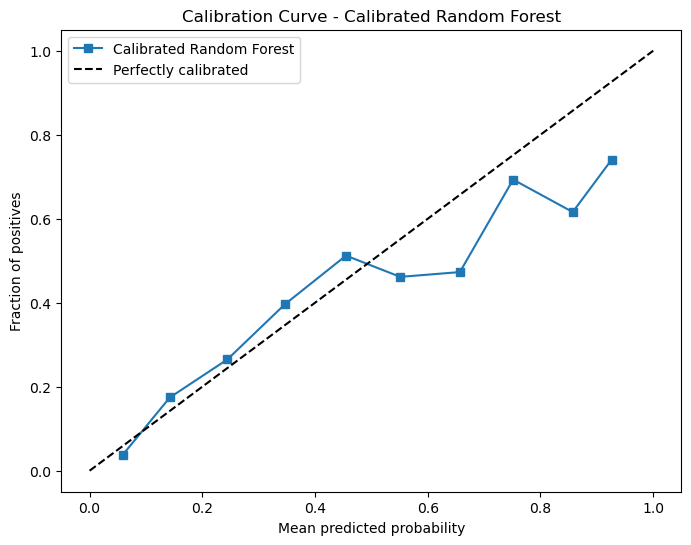

In [67]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt

# Calibrate the Random Forest model using Platt scaling (sigmoid) or isotonic regression
# We will use sigmoid as the initial method
calibrated_rf = CalibratedClassifierCV(final_model_pipeline, method='sigmoid', cv=5)
calibrated_rf.fit(X_train, y_train)

# Make predictions on the test set with the calibrated model
y_pred_calibrated = calibrated_rf.predict(X_test)
y_pred_proba_calibrated = calibrated_rf.predict_proba(X_test)[:, 1]

# Compute calibration curve for the calibrated model
RF_frac_pos, RF_mean_pred = calibration_curve(y_test, y_pred_proba_calibrated, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(RF_mean_pred, RF_frac_pos, "s-", label="Calibrated Random Forest")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve - Calibrated Random Forest")
plt.legend(loc="upper left")
plt.show()

In [68]:
# Print final evaluation metrics with the calibrated model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

accuracy = accuracy_score(y_test, y_pred_calibrated)
precision = precision_score(y_test, y_pred_calibrated)
recall = recall_score(y_test, y_pred_calibrated)
f1 = f1_score(y_test, y_pred_calibrated)
roc_auc = roc_auc_score(y_test, y_pred_proba_calibrated)

print(f"Calibrated Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_calibrated))


Calibrated Model Test Accuracy: 0.7986
Precision: 0.6250
Recall: 0.6061
F1 Score: 0.6154
ROC AUC Score: 0.8525

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1549
           1       0.62      0.61      0.62       561

    accuracy                           0.80      2110
   macro avg       0.74      0.74      0.74      2110
weighted avg       0.80      0.80      0.80      2110



#### XGBoost with Optuna for Hyperparameter Tuning

In [77]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
import optuna

# Define the objective function for Optuna to tune XGBoost hyperparameters
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'use_label_encoder': False,
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    
    # Initialize the model with parameters
    model = xgb.XGBClassifier(**param, random_state=42)
    
    # Perform cross-validation
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score


In [78]:
# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
best_params = study.best_params

print("Best hyperparameters:", best_params)

# Train the final XGBoost model with the best hyperparameters
final_xgb_model = xgb.XGBClassifier(**best_params, random_state=42, use_label_encoder=False)
final_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = final_xgb_model.predict(X_test)
y_pred_proba_xgb = final_xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the XGBoost model
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"XGBoost Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

[I 2024-11-13 17:41:40,561] A new study created in memory with name: no-name-f6a834c4-bbe5-4eab-9c4a-bc8e83be6037
[I 2024-11-13 17:42:18,322] Trial 0 finished with value: 0.8247239059152888 and parameters: {'n_estimators': 343, 'max_depth': 5, 'learning_rate': 0.16565543066762048, 'subsample': 0.7634778259763475, 'colsample_bytree': 0.8009816901571355, 'gamma': 3.2805170577065783, 'min_child_weight': 5}. Best is trial 0 with value: 0.8247239059152888.
[I 2024-11-13 17:42:58,409] Trial 1 finished with value: 0.8305356756331576 and parameters: {'n_estimators': 317, 'max_depth': 9, 'learning_rate': 0.057722227725060506, 'subsample': 0.7584811148221802, 'colsample_bytree': 0.8573860259776787, 'gamma': 2.682915325684835, 'min_child_weight': 6}. Best is trial 1 with value: 0.8305356756331576.
[I 2024-11-13 17:43:21,678] Trial 2 finished with value: 0.8248622759166725 and parameters: {'n_estimators': 104, 'max_depth': 10, 'learning_rate': 0.10903207996968767, 'subsample': 0.8809938680591154, 

Best hyperparameters: {'n_estimators': 366, 'max_depth': 10, 'learning_rate': 0.0442175149753013, 'subsample': 0.7932281146061145, 'colsample_bytree': 0.7635525362264494, 'gamma': 1.6106229752464767, 'min_child_weight': 4}
XGBoost Model Test Accuracy: 0.8038
Precision: 0.6252
Recall: 0.6542
F1 Score: 0.6394
ROC AUC Score: 0.8632

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1549
           1       0.63      0.65      0.64       561

    accuracy                           0.80      2110
   macro avg       0.75      0.76      0.75      2110
weighted avg       0.81      0.80      0.81      2110



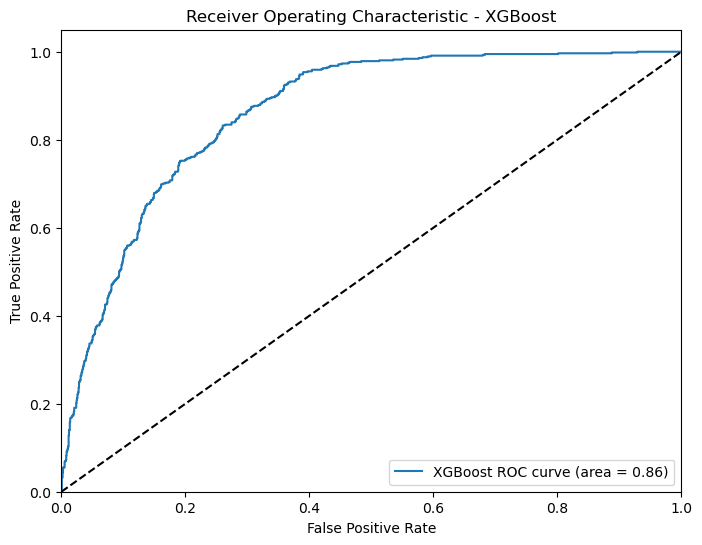

In [79]:
# Plotting the ROC Curve for the XGBoost model
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="XGBoost ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - XGBoost")
plt.legend(loc="lower right")
plt.show()

#### Calibrate XGBoost

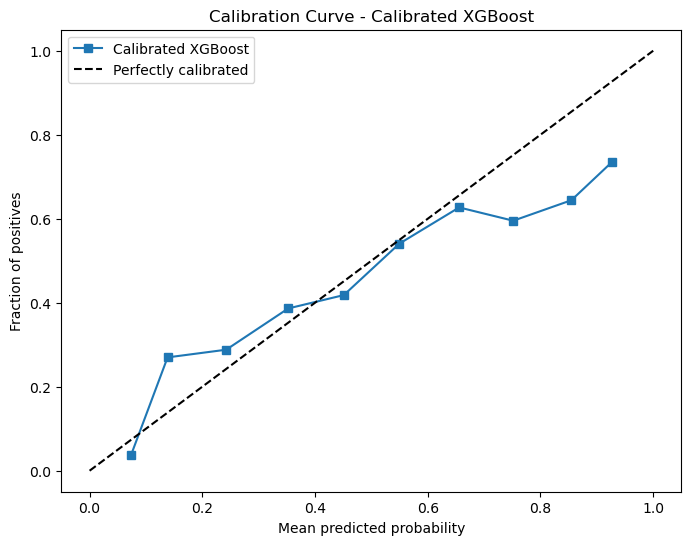

Calibrated XGBoost Model Test Accuracy: 0.8109
Precision: 0.6523
Recall: 0.6185
F1 Score: 0.6349
ROC AUC Score: 0.8644


In [80]:
# Calibrate the XGBoost model using sigmoid method
calibrated_xgb = CalibratedClassifierCV(final_xgb_model, method='sigmoid', cv=5)
calibrated_xgb.fit(X_train,y_train)

# Get calibrated probabilities
y_pred_proba_calibrated_xgb = calibrated_xgb.predict_proba(X_test)[:, 1]

# Compute calibration curve
xgb_frac_pos, xgb_mean_pred = calibration_curve(y_test, y_pred_proba_calibrated_xgb, n_bins=10)

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(xgb_mean_pred, xgb_frac_pos, "s-", label="Calibrated XGBoost")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve - Calibrated XGBoost")
plt.legend(loc="upper left")
plt.show()

# Print final evaluation metrics for the calibrated model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, calibrated_xgb.predict(X_test))
precision = precision_score(y_test, calibrated_xgb.predict(X_test))
recall = recall_score(y_test, calibrated_xgb.predict(X_test))
f1 = f1_score(y_test, calibrated_xgb.predict(X_test))
roc_auc = roc_auc_score(y_test, y_pred_proba_calibrated_xgb)

print(f"Calibrated XGBoost Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")


#### Compare all the models

In [82]:
# Dictionary to store model results
results = {}

# 1. Logistic Regression (Ridge)
results['Logistic Ridge'] = {
    'Accuracy': ridge_accuracy,
    'Precision': ridge_precision,
    'Recall': ridge_recall,
    'ROC AUC': ridge_auc
}

# 2. Logistic Regression (Lasso)
results['Logistic Lasso'] = {
    'Accuracy': lasso_accuracy,
    'Precision': lasso_precision,
    'Recall': lasso_recall,
    'ROC AUC': lasso_auc
}

# 3. Random Forest (Calibrated)
results['Random Forest (Calibrated)'] = {
    'Accuracy': accuracy_score(y_test, y_pred_calibrated),
    'Precision': precision_score(y_test, y_pred_calibrated),
    'Recall': recall_score(y_test, y_pred_calibrated),
    'F1 Score': f1_score(y_test, y_pred_calibrated),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba_calibrated)
}

# 4. XGBoost (Calibrated)
results['XGBoost (Calibrated)'] = {
    'Accuracy': accuracy_score(y_test, calibrated_xgb.predict(X_test)),
    'Precision': precision_score(y_test, calibrated_xgb.predict(X_test)),
    'Recall': recall_score(y_test, calibrated_xgb.predict(X_test)),
    'F1 Score': f1_score(y_test, calibrated_xgb.predict(X_test)),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba_calibrated_xgb)
}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Display results
print("Model Comparison:")
print(results_df)


Model Comparison:
                            Accuracy  Precision    Recall   ROC AUC  F1 Score
Logistic Ridge              0.666351   0.439560  0.926916  0.845059       NaN
Logistic Lasso              0.783412   0.571233  0.743316  0.852602       NaN
Random Forest (Calibrated)  0.798578   0.625000  0.606061  0.852534  0.615385
XGBoost (Calibrated)        0.810900   0.652256  0.618538  0.864362  0.634950
